In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets , LaTeXStrings 
using Optim
using KernelFunctions, MAT,LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, kernelmatrix 
import ReactiveMP: approximate_meancov, WishartFast
import StatsFuns: normcdf, normccdf, normlogcdf, normlogccdf, normlogpdf, normpdf, logsumexp

In [3]:
include("UnivariateSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
Random.seed!(145)
xmin, xmax = -5, 5  # Bounds of the data
N          = 100 # Number of samples
xtrain     = sort(rand(Uniform(xmin, xmax), N))
xtest      = collect(range(xmin, xmax; length=400));
kernelfunc =  2*with_lengthscale(SEKernel(),1.2)
meanfunc   = (x) -> 0.0;
grammatrix = kernelmatrix(kernelfunc,xtrain,xtrain) + 1e-6*diageye(N)
ytrain     = rand(MvNormal(zeros(length(xtrain)),grammatrix))
p          = normcdf.(ytrain)
ytrainbin  = map(rand,Bernoulli.(p));
ytrainbin = float(ytrainbin);

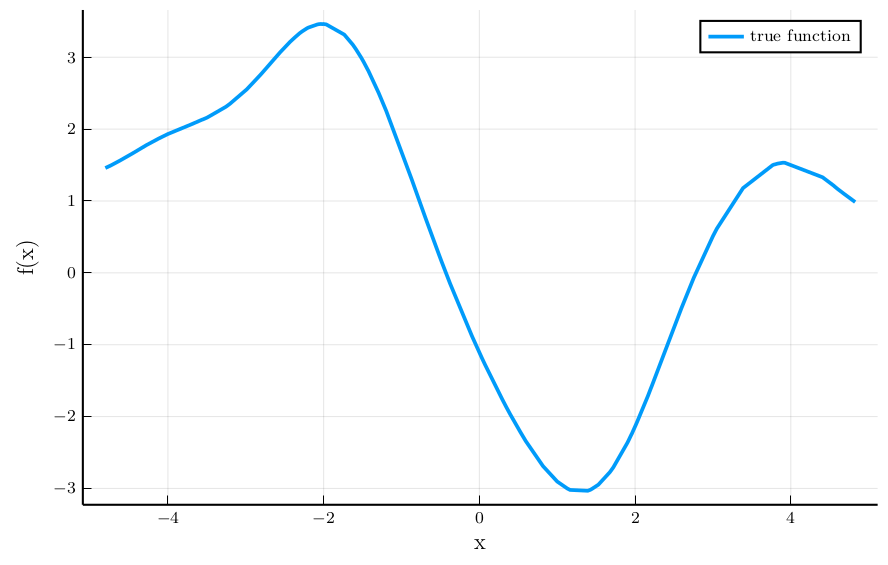

In [5]:
plot(xtrain,ytrain,label="true function",lw=1.8, legend=:topright)
xlabel!("x")
ylabel!("f(x)")

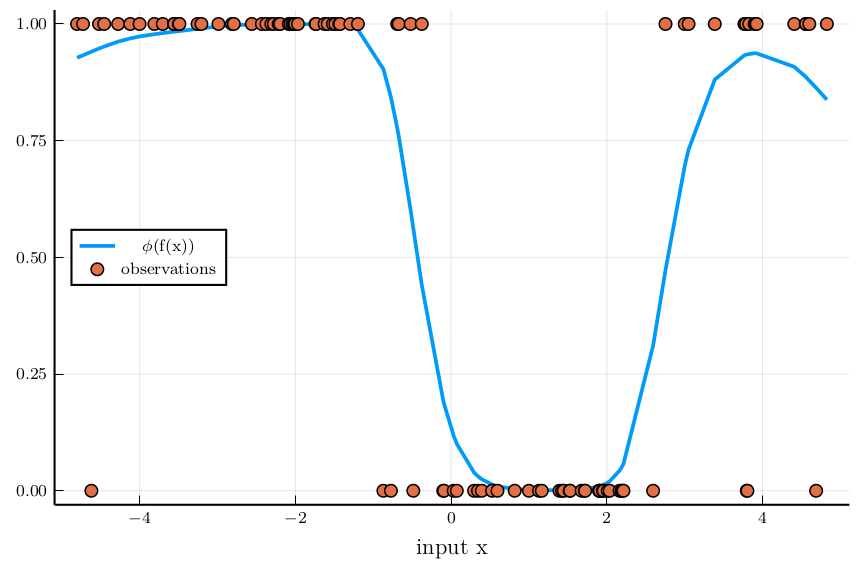

In [6]:
plot(xtrain,p,linewidth=1.8, label="ϕ(f(x))")
scatter!(xtrain,ytrainbin,legend=:left,label="observations")
xlabel!("input x")

In [15]:
@model function gp_classification(y,x,Kuu)
    v ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.01,0.01)

    for i=1:length(y)
        z[i] ~ GPTransition(x[i],v,w) 
        y[i] ~ Probit(z[i])
    end
end

In [26]:
Nu = 20; #number of inducing points 

Xu = range(-5.,5.;length=Nu);
mean_gp = (x) -> 0
kernel_gp   =  0.7*with_lengthscale(SEKernel(),1.167)

Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = inv(Kuu);

In [27]:
@meta function meta_gp_classification(Xu,Kuu_inverse,kernel)
    GPTransition() -> GPTransitionMeta(nothing,Xu,Kuu_inverse,nothing,kernel,nothing)
    Probit() -> ProbitMeta(32)
end

gp_constraint = @constraints begin
    q(z,v,w) = q(z)q(v)q(w)
end

gp_init = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    q(w) = GammaShapeRate(0.01,0.01)
end
;

In [28]:
niter = 50

infer_result = infer(
    model = gp_classification(Kuu = Kuu,),
    iterations = niter,
    data = (y = ytrainbin, x = xtrain),
    constraints = gp_constraint,
    initialization = gp_init,
    meta = meta_gp_classification(Xu,Kuu_inverse,kernel_gp),
    returnvars = (v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (w, v)
  Free Energy:     | Real[75.8605, 63.1208, 56.7591, 53.0806, 50.7442, 49.1545, 48.0149, 47.1638, 46.5065, 45.9846  …  42.2661, 42.2314, 42.1983, 42.1667, 42.1366, 42.1079, 42.0806, 42.0546, 42.0298, 42.0061]


In [29]:
qv = infer_result.posteriors[:v]
qw = infer_result.posteriors[:w];

In [30]:
function predict_new(x_test,qv,qw, meta)
    prediction_z = @call_rule GPTransition(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw, meta=meta)
    prediction_y = @call_rule Probit(:out, Marginalisation) (m_in=prediction_z,meta=ProbitMeta(32))
    return prediction_z, prediction_y
end

predict_new (generic function with 1 method)

In [31]:
predict_mean =[]
predict_var =[]
predict_func=[]
predict_var_func=[]
for i=1:length(xtest)
    prediction_z, prediction_y = predict_new(xtest[i],qv,qw,GPTransitionMeta(Xu,Kuu_inverse,nothing,kernel_gp,nothing))
    append!(predict_func,mean(prediction_z))
    append!(predict_var_func,var(prediction_z)) 
    append!(predict_mean,mean(prediction_y))
    append!(predict_var,var(prediction_y)) 
end

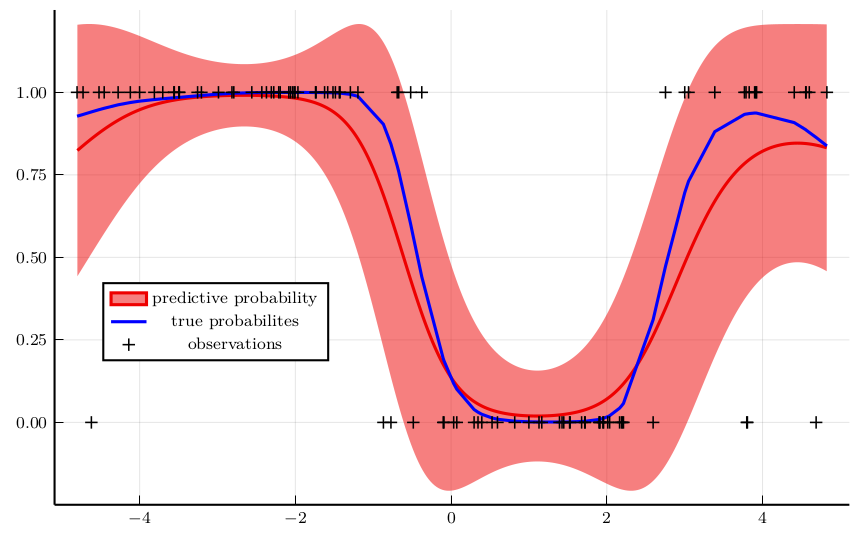

In [32]:
plot(xtest[9:393],predict_mean[9:393],ribbon = sqrt.(predict_var[9:393]),
    lw=1.5,label="predictive probability",color=:red2)
plot!(xtrain,p,linewidth=1.5,label="true probabilites",legend_position=(0.06,0.45),color=:blue)
scatter!(xtrain,ytrainbin,label="observations",marker=:cross)

In [42]:
savefig("texfiles/classification_ProbabilityResult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/classification_ProbabilityResult.svg"

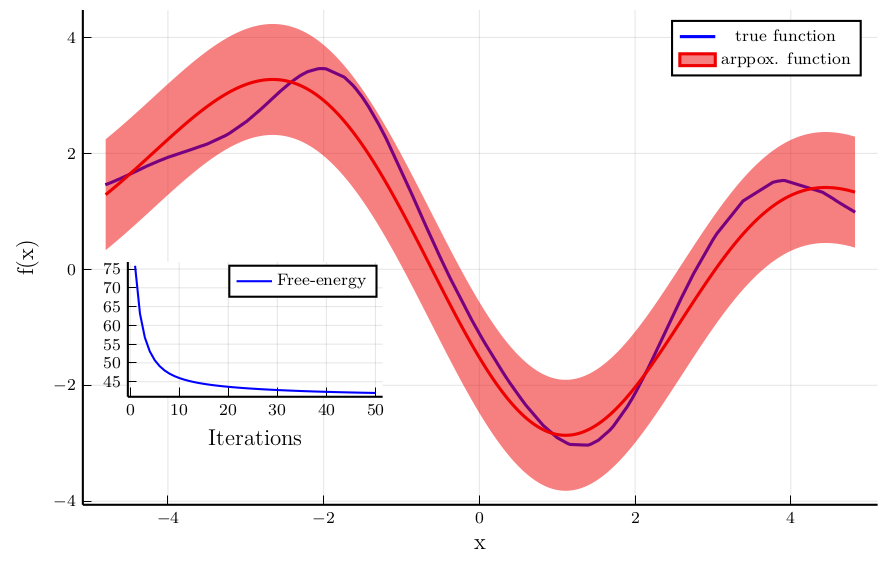

In [33]:
plot(xtrain,ytrain,label="true function",lw=1.5,color=:blue)
plot!(xtest[9:393],predict_func[9:393],ribbon = sqrt.(predict_var_func[9:393]),
     label="arppox. function",lw=1.5, legend=:topright, color=:red2)
xlabel!("x")
ylabel!("f(x)")
plot!(infer_result.free_energy,label="Free-energy", legend=:topright, 
        xlabel="Iterations",
        color=:blue,
        inset = (1, bbox(0.05, 0.18, 0.4, 0.4, :bottom, :left)),
        subplot = 2)

In [44]:
savefig("texfiles/classification_FunctionResult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/classification_FunctionResult.svg"

## Optimize

In [34]:
kernel_gp_param = (θ) -> θ[1]* with_lengthscale(SEKernel(),θ[2]); 
kernelmatrix_param = (θ) -> kernelmatrix(kernel_gp_param(θ),Xu,Xu);
function my_free_energy(θ)
    my_Kuu = kernelmatrix_param(θ)
    my_Kuu_inverse = inv(my_Kuu)
    my_kernel = kernel_gp_param(θ)

    init = @initialization begin
        q(v) = MvNormalMeanCovariance(zeros(size(my_Kuu,1)), my_Kuu)
        q(w) = GammaShapeRate(0.01,0.01)
    end

    infer_result = infer(
        model = gp_classification(Kuu = my_Kuu,),
        iterations = 30,
        data = (y = ytrainbin, x = xtrain),
        initialization = init,
        constraints = gp_constraint,
        meta = meta_gp_classification(Xu,my_Kuu_inverse,my_kernel),
        free_energy = true
    )
    
    return infer_result.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [1e-1,1e-1]
    upper = [Inf,Inf]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end


learn_params (generic function with 1 method)

In [35]:
θ_init = [1.,1]
θ_optimal = learn_params(θ_init,50)

2-element Vector{Float64}:
 0.6995895206905755
 1.1653304854373765